##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

# Factorial Mixtures

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Factorial_Mixture.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Factorial_Mixture.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In this notebook we show how to use [TensorFlow Probability](https://github.com/tensorflow/probability) (TFP) to sample from a factorial Mixture of Gaussians distribution defined as:
$$p(x_1, ..., x_n) = \prod_i p_i(x_i)$$ where: $$\begin{align*} p_i &\equiv \frac{1}{K}\sum_{i=1}^K \pi_{ik}\,\text{Normal}\left(\text{loc}=\mu_{ik},\, \text{scale}=\sigma_{ik}\right)\\1&=\sum_{k=1}^K\pi_{ik}, \forall i.\hphantom{MMMMMMMMMMM}\end{align*}$$

Each variable $x_i$ is modeled as a mixture of Gaussians, and the joint distribution over all $n$ variables is a product of these densities.

Given a dataset $x^{(1)}, ..., x^{(T)}$, we  model each dataponit $x^{(j)}$ as a factorial mixture of Gaussians:
$$p(x^{(j)}) = \prod_i p_i (x_i^{(j)})$$


Factorial mixtures are a simple way of creating distributions with a small number of parameters and a large number of modes.

In [0]:
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
tfd = tfp.distributions

# Use try/except so we can easily re-execute the whole notebook.
try:
  tf.enable_eager_execution()
except:
  pass

## Build the Factorial Mixture of Gaussians using TFP

In [0]:
num_vars = 2        # Number of variables (`n` in formula).
var_dim = 1         # Dimensionality of each variable `x[i]`.
num_components = 3  # Number of components for each mixture (`K` in formula).
sigma = 5e-2        # Fixed standard deviation of each component.

# Set seed. Remove this line to generate different mixtures!
tf.set_random_seed(77)

# Choose some random (component) modes.
component_mean = tfd.Uniform().sample([num_vars, num_components, var_dim])

factorial_mog = tfd.Independent(
   tfd.MixtureSameFamily(
       # Assume uniform weight on each component.
       mixture_distribution=tfd.Categorical(
           logits=tf.zeros([num_vars, num_components])),
       components_distribution=tfd.MultivariateNormalDiag(
           loc=component_mean, scale_diag=[sigma])),
   reinterpreted_batch_ndims=1)

Notice our use of `tfd.Independent`. This "meta-distribution" applies a `reduce_sum` in the `log_prob` calculation over the rightmost `reinterpreted_batch_ndims` batch dimensions. In our case, this sums out the variables dimension leaving only the batch dimension when we compute `log_prob`.  Note that this does not affect sampling.

## Plot the Density
Compute the density on a grid of points, and show the locations of the modes with red stars. Each mode in the factorial mixture corresponds to a pair of modes from the underlying individual-variable mixture of Gaussians. We can see 9 modes in the plot below, but we only needed 6 parameters (3 to specify the locations of the modes in $x_1$, and 3 to specify the locations of the modes in $x_2$). In contrast, a mixture of Gaussians distribution in the 2d space $(x_1, x_2)$ would require 2 * 9 = 18 parameters to specify the 9 modes.

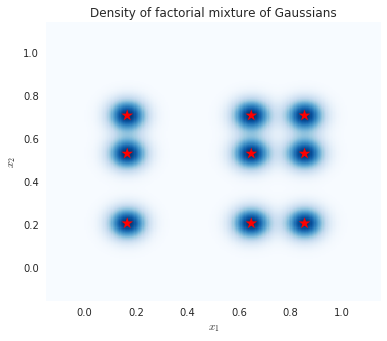

In [5]:
plt.figure(figsize=(6,5))

# Compute density.
nx = 250 # Number of bins per dimension.
x = np.linspace(-3 * sigma, 1 + 3 * sigma, nx).astype('float32')
vals = tf.reshape(tf.stack(np.meshgrid(x, x), axis=2), (-1, num_vars, var_dim))
probs = factorial_mog.prob(vals).numpy().reshape(nx, nx)

# Display as image.
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("Blues", 256))
p = plt.pcolor(x, x, probs, cmap=cmap)
ax = plt.axis('tight');

# Plot locations of means.
means_np = component_mean.numpy().squeeze()
for mu_x in means_np[0]:
  for mu_y in means_np[1]:
    plt.scatter(mu_x, mu_y, s=150, marker='*', c='r', edgecolor='none');
plt.axis(ax);

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Density of factorial mixture of Gaussians');

## Plot samples and marginal density estimates

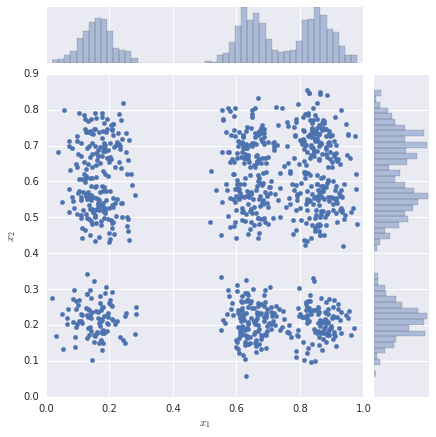

In [6]:
samples = factorial_mog.sample(1000).numpy()

g = sns.jointplot(
    x=samples[:, 0, 0],
    y=samples[:, 1, 0],
    kind="scatter",
    stat_func=None,
    marginal_kws=dict(bins=50))
g.set_axis_labels("$x_1$", "$x_2$");